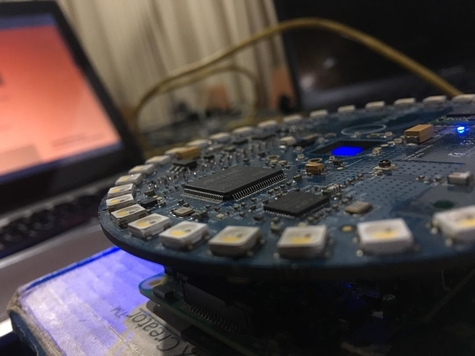

Inference test Notebook


*   Author:Appau Ernest(Team Lead -Lisa)




> This notebook provides instructions and the pipeline around detecting illegal logging activities and alerting forest Guards. 
 Solution by Team Lisa


> You can check a sample demo via this youtube link

1.   Chain Saw activity detected :-https://www.youtube.com/watch?v=eX9fJvIgLdc
2.HandSaw activity detected : - https://www.youtube.com/watch?v=gOG89k5JFGw
3.Human Activity detected :- -https://www.youtube.com/watch?v=J6DWdslo5AY




> You can find the apk for an android smartphone in this repo

1.   https://github.com/LISA-Ghana/forest_guard_ai/tree/master/apk
2.   use the credentils below:

*   Agent ID : 1234
*   Forest ID : 1










Demo

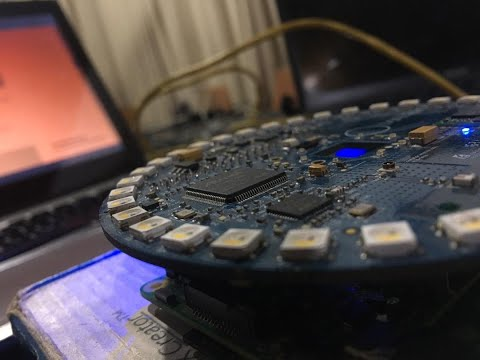

In [31]:
from IPython.display import YouTubeVideo
YouTubeVideo('eX9fJvIgLdc') 

Download and copy the json file and model file to this repo from github

In [11]:
# download the model from github
!wget 'https://github.com/LISA-Ghana/forest_guard_ai/blob/master/Models/illegal_logging_classifier_model.h5?raw=true'

# download the json file from github
!wget 'https://github.com/LISA-Ghana/forest_guard_ai/raw/master/forest-guard-ai4good-firebase-adminsdk-1fw9p-232da17716.json'


# Rename model
import os 
src = 'illegal_logging_classifier_model.h5?raw=true'
dest= 'illegal_logging_classifier_model.h5'
os.rename(src,dest)


--2020-10-29 10:41:49--  https://github.com/LISA-Ghana/forest_guard_ai/blob/master/Models/illegal_logging_classifier_model.h5?raw=true
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/LISA-Ghana/forest_guard_ai/raw/master/Models/illegal_logging_classifier_model.h5 [following]
--2020-10-29 10:41:49--  https://github.com/LISA-Ghana/forest_guard_ai/raw/master/Models/illegal_logging_classifier_model.h5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/LISA-Ghana/forest_guard_ai/master/Models/illegal_logging_classifier_model.h5 [following]
--2020-10-29 10:41:49--  https://raw.githubusercontent.com/LISA-Ghana/forest_guard_ai/master/Models/illegal_logging_classifier_model.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 

Run this utility function first

In [12]:
# we write a class for illegal logging activity detection and prediction

# we import essential models
!pip install soundfile
import librosa
import librosa.display
import soundfile as sf
import IPython.display
import numpy as np
import pandas as pd
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import vgg16
from keras.models import Model
import keras
import matplotlib.pyplot as plt

class ForestSoundDetector:
    
    
    def __init__(self, prediction_model_path=None):
        self.vgg_model = self.load_vgg_model()
        self.prediction_model = self.load_prediction_model(prediction_model_path)
        self.id_class = {'0':	'dog',
'14' :	'chirping_birds',
'36'	 : 'vacuum_cleaner',
	'19'	 : 'thunderstorm',
	'30'	 : 'door_wood_knock',
	'34'	:  'can_opening',
	'9'	:  'crow',
	'22'	: 'clapping',
	'48'	:  'fireworks',
	'41'	:  'chainsaw',
'47' :	'airplane',
	'31'	:  'mouse_click',
	'17'  :	'pouring_water',
	'45' :	'train',
'8'	: 'sheep',
	'15'	:  'water_drops',
	'46'	: 'church_bells',
	'37'	:  'clock_alarm',
	'32'	:  'keyboard_typing',
	'16'	:  'wind',
'25'	 :  'footsteps',
	'4'	:  'frog',
	'3':  'cow',
	'27' :	'brushing_teeth',
	'43'	: 'car_horn',
	'12'	:  'crackling_fire',
	'40' :	'helicopter',
	'29'	: 'drinking_sipping',
	'10' :	'rain',
	'7'	: 'insects',
	'26'	:  'laughing',
	'6'	: 'hen',
	'44'	: 'engine',
	'23'	: 'breathing',
	'20'	:  'crying_baby',
	'49'	:  'hand_saw',
	'24'	:  'coughing',
	'39'	: 'glass_breaking',
	'28'	: 'snoring',
	'18'	: 'toilet_flush',
	'2'	: 'pig',
	'35'	: 'washing_machine',
	'38'	 : 'clock_tick',
	'21'	: 'sneezing',
	'1'	: 'rooster',
	'11'	: 'sea_waves',
	'42'	: 'siren',
	'5'	: 'cat',
	'33'	: 'door_wood_creaks',
	'13'	: 'crickets'} 

        self.predicted_class = None
        self.predicted_label = None
        
    #function for loading VGG 16 model 
    def load_vgg_model(self):
        vgg_16 = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=(64, 64, 3))
        output = vgg_16.layers[-1].output
        output = keras.layers.Flatten()(output)
        model = Model(vgg_16.input, output)
        model.trainable = False
        return model
    
    # function for loading prediction model
    def load_prediction_model(self, model_path):
        pred_model = keras.models.load_model(model_path)
        return pred_model
    
    # function for loading raw sound files      
    def get_sound_data(self, path, sr=22050):
        data, fsr = sf.read(path)
        data_22k = librosa.resample(data.T, fsr, sr)
        if len(data_22k.shape) > 1:
            data_22k = np.average(data_22k, axis=0)
            
        return data_22k, sr
    
    # fuction to obtain the start and the end index of our audio
    def windows(self, data, window_size):
        start = 0
        while start < len(data):
            yield int(start), int(start + window_size)
            start += (window_size / 2) 
            
    # fuction to extract base features 
    def extract_base_features(self, sound_data, bands=64, frames=64):
    
        window_size = 512 * (frames - 1)  
        log_specgrams_full = []
        log_specgrams_hp = []
        
        start, end = list(self.windows(sound_data, window_size))[0]
        
        if(len(sound_data[start:end]) == window_size):
            signal = sound_data[start:end]

            melspec_full = librosa.feature.melspectrogram(signal, n_mels = bands)
            logspec_full = librosa.amplitude_to_db(melspec_full)
            logspec_full = logspec_full.T.flatten()[:, np.newaxis].T

            y_harmonic, y_percussive = librosa.effects.hpss(signal)
            melspec_harmonic = librosa.feature.melspectrogram(y_harmonic, n_mels = bands)
            melspec_percussive = librosa.feature.melspectrogram(y_percussive, n_mels = bands)
            logspec_harmonic = librosa.amplitude_to_db(melspec_harmonic)
            logspec_percussive = librosa.amplitude_to_db(melspec_percussive)
            logspec_harmonic = logspec_harmonic.T.flatten()[:, np.newaxis].T
            logspec_percussive = logspec_percussive.T.flatten()[:, np.newaxis].T
            logspec_hp = np.average([logspec_harmonic, logspec_percussive], axis=0)

            log_specgrams_full.append(logspec_full)
            log_specgrams_hp.append(logspec_hp)

        log_specgrams_full = np.asarray(log_specgrams_full).reshape(len(log_specgrams_full), bands ,frames, 1)
        log_specgrams_hp = np.asarray(log_specgrams_hp).reshape(len(log_specgrams_hp), bands ,frames, 1)
        features = np.concatenate((log_specgrams_full, 
                                   log_specgrams_hp, 
                                   np.zeros(np.shape(log_specgrams_full))), 
                                  axis=3)

        for i in range(len(features)):
            features[i, :, :, 2] = librosa.feature.delta(features[i, :, :, 0])

        return np.array(features)
    
    # function to extract features from our custom vgg model
    def extract_transfer_learn_features(self, base_feature_data):
        
        base_feature_data = np.expand_dims(base_feature_data, axis=0)
        model = self.vgg_model
        tl_features = model.predict(base_feature_data)
        tl_features = np.reshape(tl_features, tl_features.shape[1])
        return tl_features
    
    # function to perfom base feature extraction operation and transferlearning operations extraction
    def feature_engineering(self, audio_data):
        base_features = self.extract_base_features(sound_data=audio_data)
        final_feature_map = self.extract_transfer_learn_features(base_features[0])
        return final_feature_map
    
    # prediction function based on model
    def prediction(self, feature_map):
        model = self.prediction_model
        feature_map = feature_map.reshape(1, -1)
        pred_class = model.predict_classes(feature_map, verbose=0)
        return pred_class[0]

  
    # final prediction pipeline for keras model ,made up of the other util functions
    def prediction_pipeline(self, audio_file_path, return_class_label=True):
        
        audio_data, sr = self.get_sound_data(audio_file_path)
        feature_map = self.feature_engineering(audio_data)
        prediction_class = self.prediction(feature_map)
        self.predicted_class = prediction_class
        self.predicted_label = self.id_class[str(self.predicted_class)]  
        if return_class_label:
            return self.predicted_label
        else:
            return self.predicted_class
      
"""
To write this piece of code I took inspiration from the ff srcs
Here are some of the references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
!pip install ffmpeg-python
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr




  

In [17]:
# Final workflow for sending meta data to firebase upon human or logging activity detection the raspberry pi

# install this library to help record audio files 
# !pip install sounddevice
# # !sudo apt-get install libportaudio2
# 
# import essential libraries 
import firebase_admin
from firebase_admin import credentials
from google.cloud import firestore
import os
import glob
# import sounddevice as sd
from scipy.io.wavfile import write

# define the directories for the following files

# assign file audio path 
# detected_audio = 

# json file for firbase auth
jsonfile_dir = '/content/forest-guard-ai4good-firebase-adminsdk-1fw9p-232da17716.json'

# path to your inference model
inference_model_dir = '/content/illegal_logging_classifier_model.h5'

# specfic list of activities we want our model to detect 
activities_detected  = ['chainsaw','fireworks','engine','hand_saw','laughing','car_horn','brushing_teeth','footsteps','clapping','crackling_fire','coughing','snoring','sneezing','siren']


# configure the firestore realtime database
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=jsonfile_dir
if not firebase_admin._apps:
        cred = credentials.Certificate(jsonfile_dir) 
        default_app = firebase_admin.initialize_app(cred)

db = firestore.Client()
doc_ref = db.collection('activities').document('FpTJvCvMXNvKBHNZQ2WE')


# workflow------------------------------------------------------------------------------------
# while True:
# we stream and record the audio  from the microphone sensor in 5 sec clips, save them in a dir
# we use a for loop to pick the audio clip the dir and pass it through the model
# upon prediction we delete the audio from the dir or move the audio to another dir for future use 

# -----------------------------------------------------------------------------------------------

# initialize the Forestguard AI  Model by passing in directory to the keras model
ForestAI= ForestSoundDetector(prediction_model_path=inference_model_dir)

# function to detect human or illegal logging activities 
def set_status(snd):
      model_predictions = ForestAI.prediction_pipeline(audio_file_path = snd,return_class_label=True)
      status = model_predictions
      # for i in activities_detected:
      if status == activities_detected[0] or status == activities_detected[1] or status ==activities_detected[2] or status ==activities_detected[3]:
        doc_ref.set({'type':'1' })
      elif status in activities_detected:
        doc_ref.set({'type':'2' })
      else:
        doc_ref.set({'type':'0' })
        # block of code to save memory on iot device 
      print('Audio_Activity_detected:',status)
      os.remove(snd)
      print("File Removed to save space!")

        # to do rename and move from current dir to a different dir for storage
        






Run this cell and record audio to test model

> sample youtube video with handsaw sound triggers an illegal logging activity notification in the  forest guard app 

*   handsaw activity :-https://www.youtube.com/watch?v=U9ZaH-Pboi4

> when running the cell below,it starts recording the audio in the backround as input, a button appears , press to stop recording after a 4 secs(optimum) to save and pass audio as input to the model








In [19]:
# run this cell to record your audio
# press the stop button to stop recording
audio, sr = get_audio()

# press the stop button to stop recording

# save the audio file to your directory
import scipy
scipy.io.wavfile.write('recorded.wav', sr, audio)

# assign recorded audio to a variable
detected_audio = 'recorded.wav'

# run inference 
set_status(detected_audio)

Audio_Activity_detected: hand_saw
File Removed to save space!


In conclusion, we hope to improve this model with more trainiing data and finetuning techniques for pratical deployments in rainforest regions in Ghana to help prevent illegal logging activities by early detecction and response time of forest guards.
